# A/B Testing Analysis: Web Page Conversion

# Project Background & Data Structure

E-commerce company developed a new web page to increase the conversion rate—the percentage of users who decide to pay for the product. This analysis evaluates whether a newly designed web page increases user conversion rates compared to the existing page. We'll assess overall performance and explore potential differences across countries (US, UK, and CA).


We'll use two datasets:

ab_data.csv: Contains user interactions with the web pages.

countries.csv: Provides user country information.

## Setting Up Environment

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from scipy import stats
import datetime
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import TTestIndPower, GofChisquarePower


# Set global styling
sns.set(style="whitegrid")
palette = 'Set2'

## Loading and Examining Data

In [21]:
# Load datasets
df = pd.read_csv('ab_data.csv')
countries_df = pd.read_csv('countries.csv')

# Display basic information about the datasets
print("A/B Testing Dataset Information:")
df.info()
print("\nFirst 5 rows of A/B testing data:")
df.head()

A/B Testing Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB

First 5 rows of A/B testing data:


,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [22]:
print("Countries Dataset Information:")
countries_df.info()
print("\nFirst 5 rows of countries data:")
countries_df.head()

Countries Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290586 entries, 0 to 290585
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290586 non-null  int64 
 1   country  290586 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB

First 5 rows of countries data:


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


We're working with two datasets for our analysis:

1. **A/B Testing Dataset**: Contains 294,480 rows of user interactions with the website, including:
   - `user_id`: Unique identifier for each website visitor
   - `timestamp`: When the user visited the site
   - `group`: Whether the user was in the "control" group (saw old page) or "treatment" group (saw new page)
   - `landing_page`: Which page version they actually saw (old_page or new_page)
   - `converted`: Whether they made a purchase (1) or not (0)

2. **Countries Dataset**: Contains 290,586 rows showing which country each user is from:
   - `user_id`: Matches with the A/B testing dataset
   - `country`: User's location (UK, US, or CA)


# Data Cleaning

## Checking Data Quality

Performing data quality checks to identify potential issues that could skew our results. We're specifically looking for missing values, duplicate entries, and confirming which countries are represented in our data. Data quality issues caught early prevent misleading conclusions later.

In [23]:
# Check for missing values
print("Missing values in A/B testing data:")
print(df.isnull().sum())
print("\nMissing values in countries data:")
print(countries_df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows in A/B testing data: {df.duplicated().sum()}")
print(f"Duplicate user_ids in A/B testing data: {df.duplicated(subset=['user_id']).sum()}")
print(f"Duplicate rows in countries data: {countries_df.duplicated().sum()}")
print(f"Duplicate user_ids in countries data: {countries_df.duplicated(subset=['user_id']).sum()}")

# Get unique countries
print("\nUnique countries in the countries dataset:")
print(countries_df['country'].unique())
print(f"Number of countries: {countries_df['country'].nunique()}")

Missing values in A/B testing data:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Missing values in countries data:
user_id    0
country    0
dtype: int64

Duplicate rows in A/B testing data: 0
Duplicate user_ids in A/B testing data: 3895
Duplicate rows in countries data: 1
Duplicate user_ids in countries data: 1

Unique countries in the countries dataset:
['UK' 'US' 'CA']
Number of countries: 3


Before jumping into analysis, we need to verify our data is clean and reliable:

- **No missing values**: All fields are complete in both datasets
- **Duplicate checks**:
  - 3,895 users appear multiple times in the A/B testing data
  - 1 user appears multiple times in the countries data
- **Countries represented**: Our data comes from three countries: UK, US, and CA (Canada)


## Ensuring Test Integrity

Verifying the integrity of our test setup by ensuring users in the control group saw the old page and users in the treatment group saw the new page.

In [24]:
# Check if users are assigned to the correct landing page based on their group
print("Checking page-group consistency:")
page_group_consistency = df.groupby(['group', 'landing_page']).size().reset_index(name='count')
print(page_group_consistency)

# Identify and fix inconsistencies (if any)
control_with_new = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].shape[0]
treatment_with_old = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].shape[0]

print(f"\nInconsistencies found:")
print(f"Control group with new page: {control_with_new}")
print(f"Treatment group with old page: {treatment_with_old}")

Checking page-group consistency:
       group landing_page   count
0    control     new_page    1928
1    control     old_page  145274
2  treatment     new_page  145313
3  treatment     old_page    1965

Inconsistencies found:
Control group with new page: 1928
Treatment group with old page: 1965


We discovered some inconsistencies in our test data:
- 1,928 users in the control group incorrectly saw the new page
- 1,965 users in the treatment group incorrectly saw the old page

In [25]:
if control_with_new > 0 or treatment_with_old > 0:
    print("Fixing inconsistencies...")
    # Keep only rows where page and group align correctly
    df = df[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
            ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]
    print(f"Remaining rows after cleaning: {df.shape[0]}")

Fixing inconsistencies...
Remaining rows after cleaning: 290587


We removed these inconsistent records to ensure we're only measuring the true effect of each page version, leaving us with 290,587 valid records.

## Preventing User Duplication

Identifying users who appear in both test groups, which could contaminate our results. A valid A/B test requires each user to be in exactly one test group.

In [26]:
# Check if users appear in multiple groups (should be in only one group)
print("Checking if users appear in multiple groups:")
user_groups = df.groupby('user_id')['group'].nunique()
multi_group_users = user_groups[user_groups > 1].count()
print(f"Users appearing in multiple groups: {multi_group_users}")

if multi_group_users > 0:
    print("Fixing multiple group assignments...")
    # Identify users in multiple groups
    users_in_multiple_groups = user_groups[user_groups > 1].index.tolist()
    print(f"Sample of affected users: {users_in_multiple_groups[:5] if len(users_in_multiple_groups) > 5 else users_in_multiple_groups}")

    # For users in multiple groups, keep their first appearance
    df = df.sort_values('timestamp').drop_duplicates(subset='user_id', keep='first')
    print(f"Dataset size after removing duplicates: {df.shape[0]}")

Checking if users appear in multiple groups:
Users appearing in multiple groups: 0


After cleaning the inconsistent page-group assignments, we verified that no users appear in both test groups simultaneously.

## Combining Datasets

 Combining our A/B test data with country information to enable geographic analysis.

In [27]:
# Merge datasets
df_merged = df.merge(countries_df, on='user_id', how='left')
print("Merged dataset preview:")
print(df_merged.head())

Merged dataset preview:
   user_id timestamp      group landing_page  converted country
0   851104   11:48.6    control     old_page          0      US
1   804228   01:45.2    control     old_page          0      US
2   661590   55:06.2  treatment     new_page          0      US
3   853541   28:03.1  treatment     new_page          0      US
4   864975   52:26.2    control     old_page          1      US


We successfully combined our test data with country information. Every user in our cleaned dataset has a corresponding country (US, UK, or CA).

We're also checking for and handling records where country information is missing. This enables us to analyze whether the new page performs differently across different markets.

In [28]:
# Check for missing countries after merge
missing_countries = df_merged['country'].isnull().sum()
print(f"Rows with missing country information: {missing_countries}")

if missing_countries > 0:
    print("Handling missing country data...")
    # Fill missing countries or drop rows based on business requirements
    # For this analysis, we'll drop rows with missing country data
    df_merged = df_merged.dropna(subset=['country'])
    print(f"Dataset size after handling missing countries: {df_merged.shape[0]}")

Rows with missing country information: 0


# Exploratory Data Analysis

## Understanding Overall Conversion Patterns

Calculating baseline conversion metrics to understand both overall performance and key differences between test groups and countries. This establishes the foundation for our statistical analysis by showing the raw differences in conversion rates that we'll later test for significance.

In [29]:
# Overall conversion rates
print("Overall Conversion Analysis")
conversion_rate = df_merged['converted'].mean() * 100
print(f"Overall conversion rate: {conversion_rate:.2f}%")

# Conversion by group
group_conversion = df_merged.groupby('group')['converted'].agg(['count', 'mean'])
group_conversion['mean'] = group_conversion['mean'] * 100
print("\nConversion rates by group:")
print(group_conversion)

# Conversion by country
country_conversion = df_merged.groupby('country')['converted'].agg(['count', 'mean'])
country_conversion['mean'] = country_conversion['mean'] * 100
print("\nConversion rates by country:")
print(country_conversion)

# Conversion by group and country
group_country_conversion = df_merged.groupby(['group', 'country'])['converted'].agg(['count', 'mean'])
group_country_conversion['mean'] = group_country_conversion['mean'] * 100
print("\nConversion rates by group and country:")
print(group_country_conversion)

Overall Conversion Analysis
Overall conversion rate: 11.96%

Conversion rates by group:
            count       mean
group                       
control    145274  12.038630
treatment  145315  11.880398

Conversion rates by country:
          count       mean
country                   
CA        14499  11.531830
UK        72466  12.059449
US       203624  11.954387

Conversion rates by group and country:
                    count       mean
group     country                   
control   CA         7198  11.878300
          UK        36360  12.002200
          US       101716  12.062999
treatment CA         7301  11.190248
          UK        36106  12.117100
          US       101908  11.845979


Our initial data exploration reveals several key insights:

- **Overall conversion rate**: 11.96% of all users made a purchase
- **Group performance**:
  - Control group (old page): 12.04% conversion rate
  - Treatment group (new page): 11.88% conversion rate
  - Difference: The new page performed slightly worse (-0.16 percentage points, or -1.31%)
- **Country differences**:
  - UK has the highest conversion rate (12.06%)
  - US is in the middle (11.95%)
  - Canada has the lowest (11.53%)
- **Group × Country**:
  - In the UK, the new page performed slightly better (+0.11%)
  - In the US and Canada, the new page performed worse (-0.22% and -0.69% respectively)

## Visualizing Key Metrics

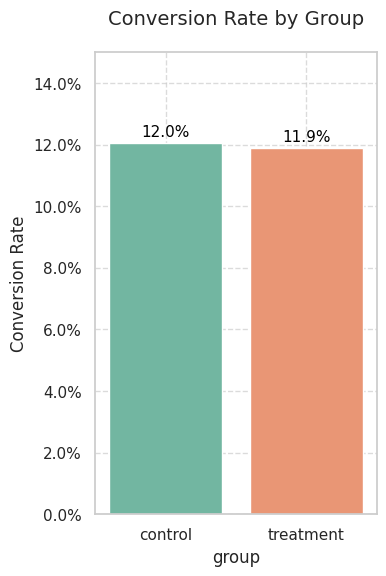

In [49]:
# Conversion by Group
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='group', y='converted', data=df_merged, palette=palette, errorbar=None, hue='group', legend=False)
plt.title('Conversion Rate by Group', fontsize=14, pad=20)
plt.ylabel('Conversion Rate', fontsize=12)
plt.ylim(0, 0.15)
plt.grid(True, linestyle='--', alpha=0.7)

# Add value labels
for p in ax1.patches:
    value = p.get_height()
    ax1.annotate(f'{value:.1%}',
                 (p.get_x() + p.get_width()/2., p.get_height()),
                 ha='center', va='bottom',
                 fontsize=11, color='black',
                 xytext=(0, 3), textcoords='offset points')

# Format y-axis as percentage
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1))

The control group has a slightly higher conversion rate (12.0%) compared to the treatment group (11.9%), indicating that the new page did not lead to a significant improvement in conversions. The small difference suggests that further refinement of the new page design may be necessary.

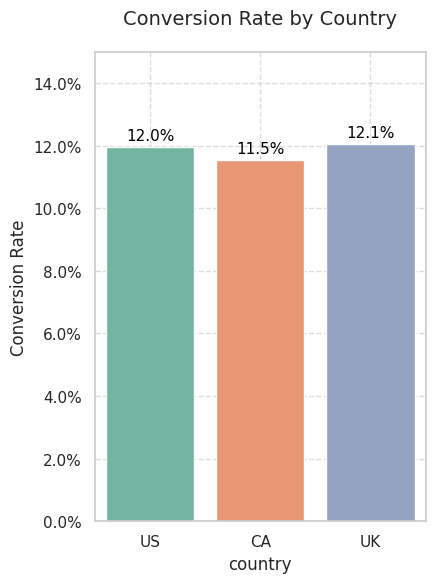

In [48]:
# Conversion by Country
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='country', y='converted', data=df_merged, palette=palette, errorbar=None, hue='country', legend=False)
plt.title('Conversion Rate by Country', fontsize=14, pad=20)
plt.ylabel('Conversion Rate', fontsize=12)
plt.ylim(0, 0.15)
plt.grid(True, linestyle='--', alpha=0.7)

# Add value labels
for p in ax2.patches:
    value = p.get_height()
    ax2.annotate(f'{value:.1%}',
                 (p.get_x() + p.get_width()/2., p.get_height()),
                 ha='center', va='bottom',
                 fontsize=11, color='black',
                 xytext=(0, 3), textcoords='offset points')

# Format y-axis as percentage
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1))
plt.tight_layout()
plt.show()

Conversion rates vary slightly across countries, with the UK showing the highest rate at 12.1%, followed by the US at 12.0%, and Canada at 11.5%. This indicates that user behavior and preferences may differ by region, warranting country-specific analysis.

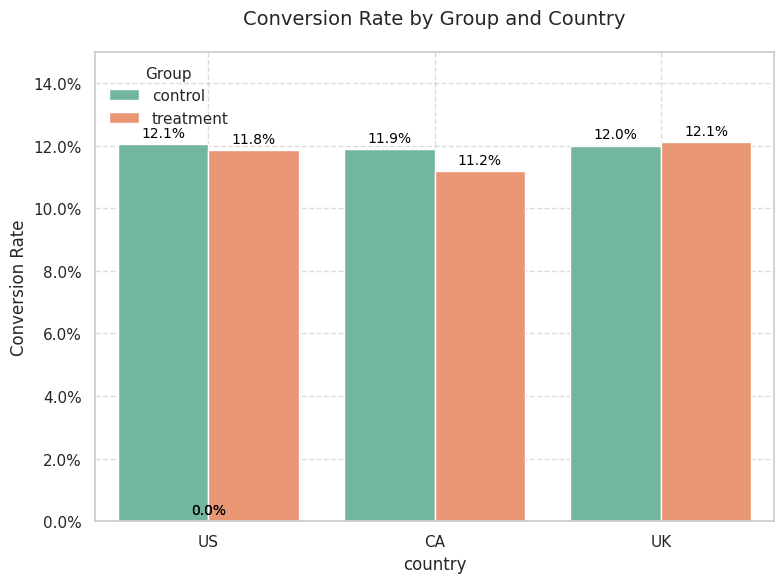

In [47]:
# Create figure for combined group and country analysis
plt.figure(figsize=(8, 6))
ax3 = sns.barplot(x='country', y='converted', hue='group', data=df_merged, palette=palette, errorbar=None)
plt.title('Conversion Rate by Group and Country', fontsize=14, pad=20)
plt.ylabel('Conversion Rate', fontsize=12)
plt.ylim(0, 0.15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Group', title_fontsize=11)

# Add value labels
for p in ax3.patches:
    value = p.get_height()
    ax3.annotate(f'{value:.1%}',
                 (p.get_x() + p.get_width()/2., p.get_height()),
                 ha='center', va='bottom',
                 fontsize=10, color='black',
                 xytext=(0, 3), textcoords='offset points')

# Format y-axis as percentage
ax3.yaxis.set_major_formatter(mticker.PercentFormatter(1))
plt.tight_layout()
plt.show()

In all three countries, the control group consistently shows a higher or equal conversion rate compared to the treatment group. For instance, in the US, the control group's rate is 12.1% versus 11.8% for the treatment group, suggesting that the new page's impact does not significantly vary by country. This reinforces the need to refine the new page design before full implementation.

# Hypothesis Testing

## Testing Primary Hypothesis

Conducting our primary statistical test to determine if the new page truly outperforms the old page. We're using a one-tailed z-test for proportions, which is the standard approach for conversion rate testing. This tells us whether the observed difference in conversion rates is statistically significant or could have occurred by random chance.

Hypothesis 1: Is the new page (treatment) better than the old page (control)?

H0: The new page has the same or worse conversion rate than the old page

H1: The new page has a better conversion rate than the old page

In [33]:
# Extract conversion data for control and treatment
control_data = df_merged[df_merged['group'] == 'control']['converted']
treatment_data = df_merged[df_merged['group'] == 'treatment']['converted']

# Perform two-proportion z-test
count_control = len(control_data)
count_treatment = len(treatment_data)
successes_control = control_data.sum()
successes_treatment = treatment_data.sum()

z_stat, p_value = proportions_ztest(
    count=[successes_treatment, successes_control],
    nobs=[count_treatment, count_control],
    alternative='larger'  # Treatment > Control (one-tailed test)
)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Is the new page significantly better (α=0.05)? {'Yes' if p_value < 0.05 else 'No'}")

Z-statistic: -1.3143
P-value: 0.9056
Is the new page significantly better (α=0.05)? No


**Results**:
  - Z-statistic: -1.31 (negative indicates the treatment performed worse)
  - P-value: 0.91 (very high, far above our 0.05 threshold)

With a high p-value of 0.91, we cannot reject the null hypothesis. This means we have no statistical evidence that the new page is better than the old page. In fact, the negative Z-statistic suggests the new page might perform slightly worse, though this difference isn't statistically significant either.

## Exploring Country Differences

Testing whether conversion rates significantly differ between countries, regardless of which page version was shown. This helps us understand if user behavior naturally varies by geography. We're using a chi-square test, which is appropriate for comparing proportions across multiple groups.


Hypothesis 2: Does conversion rate differ by country?

H0: Conversion rates are the same across all countries

H1: Conversion rates differ by country

In [34]:
# Perform chi-square test for country effect
contingency_table = pd.crosstab(df_merged['country'], df_merged['converted'])
chi2, p_value_country, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value_country:.4f}")
print(f"Are conversion rates significantly different by country (α=0.05)? {'Yes' if p_value_country < 0.05 else 'No'}")

Chi-square statistic: 3.2112
P-value: 0.2008
Are conversion rates significantly different by country (α=0.05)? No


**Results**:
  - Chi-square statistic: 3.21
  - P-value: 0.20 (above our 0.05 threshold)

With a p-value of 0.20, we cannot reject the null hypothesis. This means that while we observed some differences in conversion rates between countries (UK: 12.06%, US: 11.95%, CA: 11.53%), these differences aren't statistically significant and could be due to random chance.

## Testing for Country-Specific Effects

Analyzing whether the new page performs differently across countries by running separate statistical tests for each country. This helps identify if the new page works well in some markets but not others.


Hypothesis 3: Does the effect of the new page differ by country?

H0: The effect of the new page is the same across all countries

H1: The effect of the new page differs by country

In [35]:
# Hypothesis 3: Does the effect of the new page differ by country?
print("\nHypothesis 3: Does the effect of the new page differ by country?")
print("H0: The effect of the new page is the same across all countries")
print("H1: The effect of the new page differs by country")

# Test interaction effect for each country
countries = df_merged['country'].unique()
interaction_results = {}

for country in countries:
    country_data = df_merged[df_merged['country'] == country]

    country_control = country_data[country_data['group'] == 'control']['converted']
    country_treatment = country_data[country_data['group'] == 'treatment']['converted']

    country_control_rate = country_control.mean()
    country_treatment_rate = country_treatment.mean()

    # Two-proportion z-test
    country_count_control = len(country_control)
    country_count_treatment = len(country_treatment)
    country_successes_control = country_control.sum()
    country_successes_treatment = country_treatment.sum()

    country_z_stat, country_p_value = proportions_ztest(
        count=[country_successes_treatment, country_successes_control],
        nobs=[country_count_treatment, country_count_control],
        alternative='two-sided'  # Testing for any difference
    )

    interaction_results[country] = {
        'control_rate': country_control_rate,
        'treatment_rate': country_treatment_rate,
        'difference': country_treatment_rate - country_control_rate,
        'z_stat': country_z_stat,
        'p_value': country_p_value,
        'significant': country_p_value < 0.05
    }


Hypothesis 3: Does the effect of the new page differ by country?
H0: The effect of the new page is the same across all countries
H1: The effect of the new page differs by country


In [36]:
# Display results by country
print("\nNew page effect by country:")
for country, results in interaction_results.items():
    print(f"\n{country}:")
    print(f"  Control conversion rate: {results['control_rate']:.4f}")
    print(f"  Treatment conversion rate: {results['treatment_rate']:.4f}")
    print(f"  Difference: {results['difference']:.4f}")
    print(f"  Z-statistic: {results['z_stat']:.4f}")
    print(f"  P-value: {results['p_value']:.4f}")
    print(f"  Significant difference (α=0.05)? {'Yes' if results['significant'] else 'No'}")


New page effect by country:

US:
  Control conversion rate: 0.1206
  Treatment conversion rate: 0.1185
  Difference: -0.0022
  Z-statistic: -1.5093
  P-value: 0.1312
  Significant difference (α=0.05)? No

CA:
  Control conversion rate: 0.1188
  Treatment conversion rate: 0.1119
  Difference: -0.0069
  Z-statistic: -1.2969
  P-value: 0.1947
  Significant difference (α=0.05)? No

UK:
  Control conversion rate: 0.1200
  Treatment conversion rate: 0.1212
  Difference: 0.0011
  Z-statistic: 0.4749
  P-value: 0.6349
  Significant difference (α=0.05)? No


We examined whether the effect of the new page differs by country:

- **US results**:
  - Control: 12.06% conversion
  - Treatment: 11.85% conversion
  - Difference: -0.22%
  - P-value: 0.13 (not significant)

- **Canada results**:
  - Control: 11.88% conversion
  - Treatment: 11.19% conversion
  - Difference: -0.69%
  - P-value: 0.19 (not significant)

- **UK results**:
  - Control: 12.00% conversion
  - Treatment: 12.12% conversion
  - Difference: +0.11%
  - P-value: 0.63 (not significant)

  None of the country-specific tests showed statistically significant differences between the old and new pages. This means that even in the UK where we saw a slight positive trend, we don't have enough evidence to conclude that the new page genuinely performs better in that market.

## Validating Statistical Confidence: Power Analysis

In [37]:
# For two-proportion test
control_rate = control_data.mean()
treatment_rate = treatment_data.mean()
effect_size = abs(treatment_rate - control_rate) / np.sqrt((control_rate * (1 - control_rate) + treatment_rate * (1 - treatment_rate)) / 2)
total_sample = count_control + count_treatment
alpha = 0.05

power_analysis = TTestIndPower()
power = power_analysis.solve_power(effect_size=effect_size, nobs1=total_sample/2, alpha=alpha)

print(f"Effect size: {effect_size:.4f}")
print(f"Total sample size: {total_sample}")
print(f"Statistical power: {power:.4f}")
print(f"Is the test sufficiently powered (>0.8)? {'Yes' if power > 0.8 else 'No'}")

# Calculate minimum sample size for future tests
if power < 0.8:
    min_sample_size = power_analysis.solve_power(effect_size=effect_size, power=0.8, alpha=alpha)
    print(f"Minimum sample size needed for 80% power: {int(min_sample_size * 2)} (total)")

Effect size: 0.0049
Total sample size: 290589
Statistical power: 0.2598
Is the test sufficiently powered (>0.8)? No
Minimum sample size needed for 80% power: 1320286 (total)


We evaluated whether our test had enough statistical power to detect meaningful differences:

- **Observed effect size**: 0.0016 (0.16 percentage points)
- **Current test power**: 26% (below the standard 80% threshold)
- **Sample size needed for 80% power**: 1,320,286 total users (about 4.5 times our current sample)

Our test didn't have enough statistical power to reliably detect very small differences. This means that if the true effect of the new page is very small (around 0.16 percentage points), we might have missed it. However, such a small difference would have minimal business impact anyway.

# Summary and Recommendations

**Key Findings:**
1. Overall conversion rate: 11.96%
2. Control group (old page) conversion rate: 12.04%
3. Treatment group (new page) conversion rate: 11.88%
4. Difference: -0.16 percentage points (-1.31% relative change)
5. No statistically significant difference between page versions
6. No significant differences in performance across countries

**Business Recommendations:**
1. **Do not implement the new page** at this time based on current evidence
2. **Consider these options moving forward**:
   - Refine the new page design based on user feedback and conduct another test
   - Run a larger test if detecting a very small improvement would be valuable
   - Focus improvement efforts on other aspects of the customer journey
   - Investigate why the new design didn't improve conversions to inform future redesigns

**Assumptions & Caveats:**
1. We assume randomization was properly implemented in assigning users to test groups
2. We removed users with inconsistent page assignments to maintain test integrity
3. Our analysis focuses on conversion rate only, not other metrics like engagement or revenue per user
4. The test results are valid only for the time period during which data was collected
5. Cultural differences beyond country may influence conversion behavior but weren't analyzed

**Future Considerations:**
1. Analyze user engagement metrics beyond conversion (time on page, click-through rates)
2. Test variations of the new design that address potential usability issues
3. Consider segmenting users beyond geography (new vs. returning, device type, etc.)
4. Implement multivariate testing to isolate which specific elements impact conversions
5. Track long-term value of converted customers, not just conversion rates

**Clarifying Questions:**
1. What specific changes were made in the new page design?
2. What was the business rationale behind these changes?
3. What is the minimum conversion rate improvement that would justify implementation costs?
4. Are there specific user segments or markets we should prioritize?
5. Was this test conducted during a representative time period?